In [3]:
# Emotion Recognition for Video Dataset.
# Installing necessary packages

!pip install -U scikit-learn scipy matplotlib
!pip install scikit-plot
!pip install matplotlib==3.1.3

     |████████████████████████████████| 22.3 MB 1.2 MB/s 
     |████████████████████████████████| 28.5 MB 29 kB/s 
     |████████████████████████████████| 10.3 MB 51.6 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 13.1 MB 91 kB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.2
    Uninstalling matplotlib-3.4.2:
      Successfully uninstalled matplotlib-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
# Importing libraries

import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils
from keras.utils.vis_utils import plot_model

In [3]:
# Reading and displaying the video dataset

df_video_data = pd.read_csv("/content/fer2013.csv")
print(df_video_data.shape)
#df_video_data.head()
df_video_data

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [4]:
# Printing Unique emotions
print('Unique Emotions:', df_video_data.emotion.unique())

Unique Emotions: [0 2 4 6 3 5 1]


In [5]:
# Assigning the above Emotions with Labels
emotion_dict_labels_to_text = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness', 4: 'Sadness', 5: 'Surprise', 6: 'Neutral'}

# Unicodes for the above emotions
emotion_emoji = { 0:"\U0001f620",1:"\U0001f922" ,2:"\U0001f628" ,3:"\U0001f60A" , 4:"\U0001f625" ,5:"\U0001f632",6:"\U0001f610" }
print(emotion_emoji.values())

dict_values(['😠', '🤢', '😨', '😊', '😥', '😲', '😐'])


In [6]:
# Total count for each of the emotion
df_video_data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

Distribution of count for each emotion


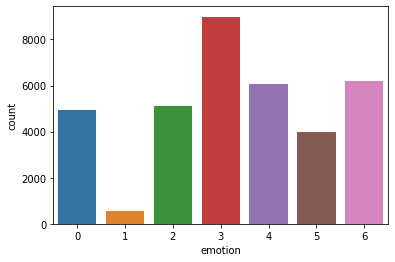

In [7]:
# Visualization - graphically to show the total count of each emotion

print('Distribution of count for each emotion')
sns.countplot(x='emotion', data=df_video_data)
plt.show()

Displaying distribution count of eash Usage category:
  Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64


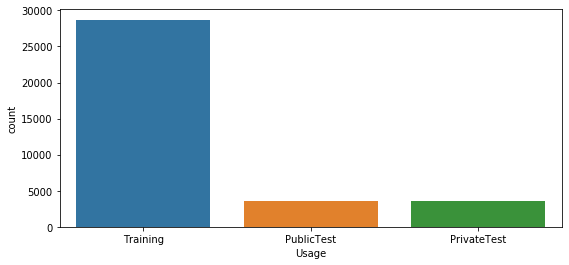

In [8]:
# Visualization - graphically to show the Usage column of video dataset

plt.figure(figsize=(9,4))
print('Displaying distribution count of eash Usage category:\n ', df_video_data['Usage'].value_counts())
sns.countplot(x='Usage', data=df_video_data)

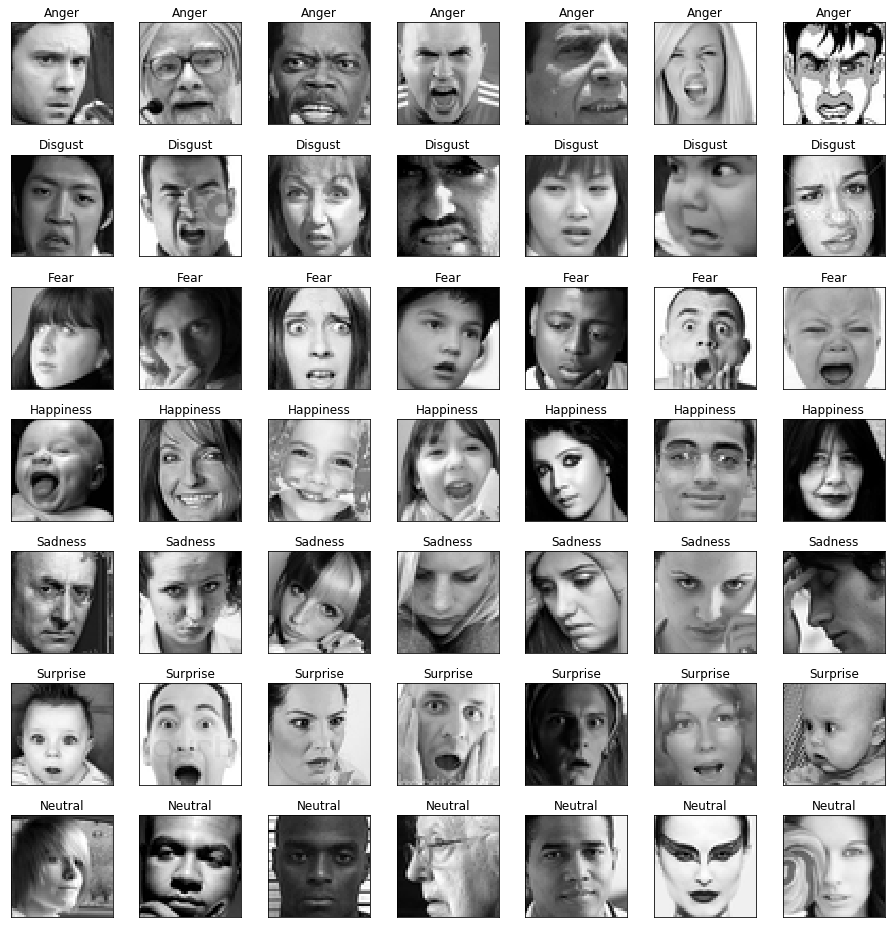

In [9]:
# Assigning emotion labels to the images in video dataset
img_fig = plt.figure(1, (13, 13))

k = 0
for label in sorted(df_video_data.emotion.unique()):
    for j in range(7):
        pix = df_video_data[df_video_data.emotion==label].pixels.iloc[k]
        pix = np.array(pix.split(' ')).reshape(48, 48).astype('float32')
        k += 1    
        axi = plt.subplot(7, 7, k)
        axi.imshow(pix, cmap='gray')
        axi.set_xticks([])
        axi.set_yticks([])
        axi.set_title(emotion_dict_labels_to_text[label])
        plt.tight_layout()

In [10]:
emotion_labels = [0, 1, 2, 3, 4, 5, 6]

In [11]:
df_video_data = df_video_data[df_video_data.emotion.isin(emotion_labels)]
df_video_data.shape

(35887, 3)

# **Pre-processing Data**
---

In [12]:
# Preparing the data to be compatible for Neural Network

#  Splitting string by space as a list and converting it to numpy array with size 48*48; and putting each image and their pixels in numpyarray form
img_array = df_video_data.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis = 0)

emotions = pd.get_dummies(df_video_data['emotion']).to_numpy()
img_array.shape


(35887, 48, 48, 1)

In [13]:
# Displaying emotions after pre-processing
print('Pre-processed emotions:', emotions[0])
print('Shaping emotions: ',emotions.shape)
print('No.of dimensions: ', emotions.ndim)
print('Type: ', type(emotions))  # checking the type

Pre-processed emotions: [1 0 0 0 0 0 0]
Shaping emotions:  (35887, 7)
No.of dimensions:  2
Type:  <class 'numpy.ndarray'>


In [14]:
# Assigning labels using LabelEncoder

le = LabelEncoder()
img_labels = le.fit_transform(df_video_data.emotion)
img_labels = np_utils.to_categorical(img_labels) # updating to integer to categorical
img_labels.shape

(35887, 7)

In [15]:
# mapping emotions to its corresponding labels

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


# **Splitting into Training and Validation Dataset**
---



In [16]:
# Data splitting into Training set and Validation/Testing set
# Here the Training Pixels and Validation Pixels displays four dimensions -> no. of samples , width , height , classes

X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                   shuffle=True, stratify=img_labels,
                                                   test_size=0.33, random_state=42) 

print('Training Pixels',X_train.shape) 
print('Training labels', y_train.shape)

print('Validation Pixels',X_valid.shape)
print('Validation labels',y_valid.shape)

Training Pixels (24044, 48, 48, 1)
Training labels (24044, 7)
Validation Pixels (11843, 48, 48, 1)
Validation labels (11843, 7)


In [17]:
# Displaying the no.of emotion classes

img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

print('No.of classes:', num_classes)

No.of classes: 7


In [18]:
# Normalizing results -> pixels division by 255 to be in range(0,1) 

X_train = X_train / 255.0
X_valid = X_valid / 255.0

# Scaling the pixels value to be in range(-1,1)
#X_train = X_train - 0.5
#X_train = X_train * 2.0

#X_valid = X_valid - 0.5
#X_valid = X_valid * 2.0

# **Defining Model**
---

In [19]:
# Building a Sequential CNN Model

def build_cnn_model(optim):   
    cnn_model = Sequential(name='DCNN')

    cnn_model.add(Conv2D(filters=64, kernel_size=(5,5), input_shape=(img_width, img_height, img_depth),
            activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_1'))
    cnn_model.add(BatchNormalization(name='batchnorm_1'))
    cnn_model.add(Conv2D(filters=64, kernel_size=(5,5), activation='elu', padding='same', kernel_initializer='he_normal',
            name='conv2d_2'))
    cnn_model.add(BatchNormalization(name='batchnorm_2'))    
    cnn_model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    cnn_model.add(Dropout(0.5, name='dropout_1'))

    cnn_model.add(Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal',
            name='conv2d_3'))
    cnn_model.add(BatchNormalization(name='batchnorm_3'))
    cnn_model.add(Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal',
            name='conv2d_4' ))
    cnn_model.add(BatchNormalization(name='batchnorm_4'))    
    cnn_model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    cnn_model.add(Dropout(0.5, name='dropout_2'))

    cnn_model.add(Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal',
            name='conv2d_5'))
    cnn_model.add(BatchNormalization(name='batchnorm_5'))
    cnn_model.add(Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal',
            name='conv2d_6' ))
    cnn_model.add(BatchNormalization(name='batchnorm_6'))    
    cnn_model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    cnn_model.add(Dropout(0.5, name='dropout_3'))

    cnn_model.add(Flatten(name='flatten'))
        
    cnn_model.add(Dense(128,activation='elu', kernel_initializer='he_normal', name='dense_1'))
    cnn_model.add(BatchNormalization(name='batchnorm_7'))    
    cnn_model.add(Dropout(0.5, name='dropout_4'))
    
    cnn_model.add(Dense(num_classes, activation='softmax',name='out_layer' ))
    
    cnn_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    cnn_model.summary()
    #plot_model(cnn_model, to_file='/content/model_images/model_plot.png', show_shapes=True, show_layer_names=True)
    return cnn_model

In [20]:
# Avoid Overfitting by using Early stopping and ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

reducelr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    reducelr_scheduler,
]

# **Data Augmentation**
---

In [21]:
# Using ImageDataGenerator as we have less data
# Increase model's generalizability -applying a series of random transformations (random rotation, resizing, shearing) 

train_imagedatagen = ImageDataGenerator(
    rotation_range=12,
    width_shift_range=0.12,
    height_shift_range=0.12,
    shear_range=0.12,
    zoom_range=0.12,
    horizontal_flip=True,
    featurewise_center=False,
    featurewise_std_normalization=False,
)
train_imagedatagen.fit(X_train)

In [22]:
# Using Nadam Optimizer
batch_size = 32 #No.of samples per gradient update
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    ]

model = build_cnn_model(optims[0]) 
history = model.fit_generator(
    train_imagedatagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


751/751 [==============================] - 57s 31ms/step - loss: 2.0414 - accuracy: 0.2456 - val_loss: 1.6575 - val_accuracy: 0.3456
Epoch 2/100
751/751 [==============================] - 23s 31ms/step - loss: 1.6553 - accuracy: 0.3479 - val_loss: 1.4267 - val_accuracy: 0.4495
Epoch 3/100
751/751 [==============================] - 23s 30ms/step - loss: 1.5065 - accuracy: 0.4154 - val_loss: 1.3482 - val_accuracy: 0.4811
Epoch 4/100
751/751 [==============================] - 23s 30ms/step - loss: 1.4119 - accuracy: 0.4569 - val_loss: 1.3133 - val_accuracy: 0.4946
Epoch 5/100
751/751 [==============================] - 26s 34ms/step - loss: 1.3511 - accuracy: 0.4871 - val_loss: 1.2787 - val_accuracy: 0.5286
Epoch 6/100
751/751 [==============================] - 23s 31ms/step - loss: 1.3097 - accuracy: 0.5038 - val_loss: 1.1692 - val_accuracy: 0.5565
Epoch 7/100
751/751 [==============================] - 25s 34ms/step - loss: 1.2746 - accuracy: 0.5154 - val_loss: 1.2143 - val_accuracy: 0.54

In [23]:
# Model evaluation to returns accuracy and loss
score = model.evaluate(X_valid, y_valid, verbose=1) 
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

371/371 [==============================] - 3s 9ms/step - loss: 0.9122 - accuracy: 0.6817
Test loss: 0.912172794342041
Test accuracy: 68.16685199737549


In [24]:
# Saving model weights
model.save_weights("model_emotion.h5")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

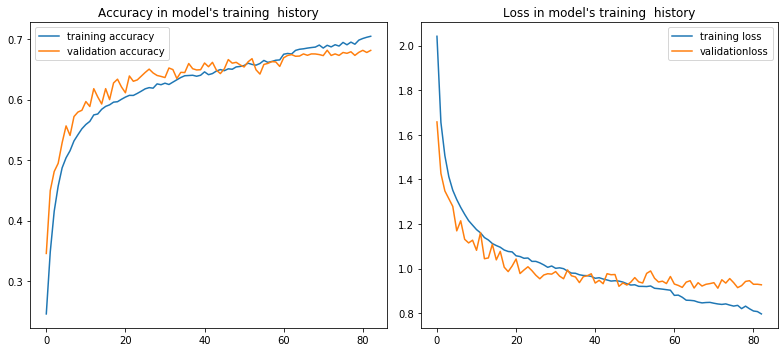

In [25]:
# Visualising training history of the model

history_fig = plt.figure(0, (11, 5))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='training accuracy')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy in model\'s training  history')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='training loss')
sns.lineplot(history.epoch, history.history['val_loss'], label='validationloss')
plt.title('Loss in model\'s training  history')
plt.tight_layout()
plt.show()

# **Performance of the model using Confusion Matrix**
---

Total no.of wrong validation predictions: 3770 


              precision    recall  f1-score   support

           0       0.59      0.62      0.60      1635
           1       0.79      0.45      0.58       181
           2       0.59      0.42      0.49      1690
           3       0.88      0.88      0.88      2966
           4       0.59      0.54      0.56      2005
           5       0.77      0.79      0.78      1321
           6       0.58      0.75      0.65      2045

    accuracy                           0.68     11843
   macro avg       0.68      0.64      0.65     11843
weighted avg       0.68      0.68      0.68     11843



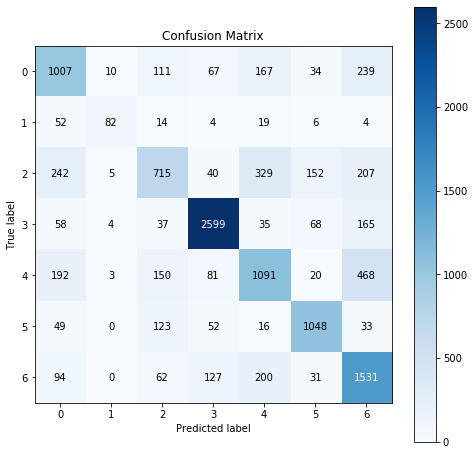

In [26]:
# Using confusion matrix to test/predict the performance of the model

yhat_valid = np.argmax(model.predict(X_valid), axis=-1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(8,8))

print('Total no.of wrong validation predictions:', np.sum(np.argmax(y_valid, axis=1) != yhat_valid) , '\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [40]:
# Mapping labels

label_mapper = {
    0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness', 4: 'Sadness', 5: 'Surprise', 6: 'Neutral'
}

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


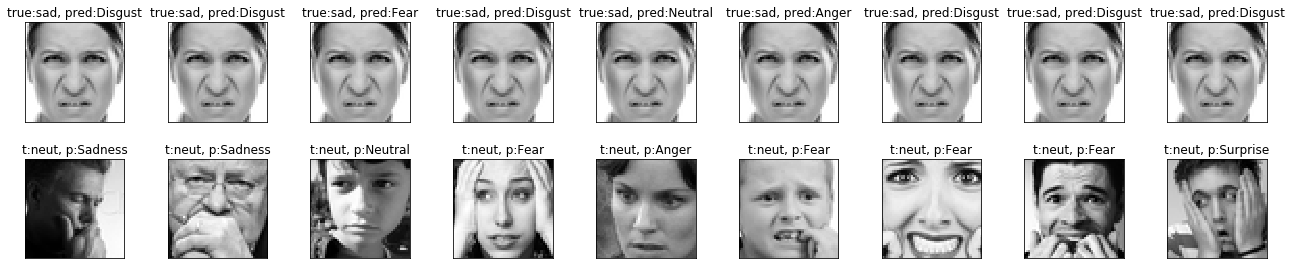

In [41]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

pred_fig = plt.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = plt.subplot(2, 9, i+1)
        preprocessed_sad_img = X_valid[sadidx,:,:,0]
        preprocessed_sad_img = preprocessed_sad_img.reshape(-1,48,48,1)       
        ax.imshow(preprocessed_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{label_mapper[model.predict_classes(preprocessed_sad_img.reshape(-1,48,48,1))[0]]}")
       #ax.set_title(f"true:sad, pred:",label_mapper[np.argmax(model.predict(preprocessed_sad_img), axis=1)])

       
        ax = plt.subplot(2, 9, i+10)
        preprocessed_neut_img = X_valid[neuidx,:,:,0]
        ax.imshow(preprocessed_neut_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{label_mapper[model.predict_classes(preprocessed_neut_img.reshape(-1,48,48,1))[0]]}")

        plt.tight_layout()